经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 本教程使用PaddlePaddle建立起一个房价预测模型。

在线性回归中：

（1）假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。 在本次线性回顾模型中，我们的假设函数为 Y’= wX+b ，其中，Y’表示模型的预测结果（预测房价），用来和真实的Y区分。模型要学习的参数即：w,b。

（2）损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。 建立模型后，我们需要给模型一个优化目标，使得学到的参数能够让预测值Y’尽可能地接近真实值Y。这个实值通常用来反映模型误差的大小。不同问题场景下采用不同的损失函数。 对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。

（3）优化算法：神经网络的训练就是调整权重（参数）使得损失函数值尽可能得小，在训练过程中，将损失函数值逐渐收敛，得到一组使得神经网络拟合真实模型的权重（参数）。所以，优化算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量w和b的值，一步一步地试出这个最小值。 常见的优化算法有随机梯度下降法（SGD）、Adam算法等等

**首先导入必要的包**，分别是：

**paddle.fluid**--->PaddlePaddle深度学习框架

**numpy**---------->python基本库，用于科学计算

**os**------------------>python的模块，可使用该模块对操作系统进行操作

**matplotlib**----->python绘图库，可方便绘制折线图、散点图等图形

In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

# **Step1：准备数据。**

（1）uci-housing数据集介绍

数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。

PaddlePaddle提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。

(2)train_reader和test_reader

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [2]:
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  
    

[==================================================]housing/housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data
/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/dataset/uci_housing.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/c

(3)打印看下数据是什么样的？PaddlePaddle接口提供的数据已经经过归一化等处理

(array([-0.02964322, -0.11363636,  0.39417967, -0.06916996,  0.14260276,
       -0.10109875,  0.30715859, -0.13176829, -0.24127857,  0.05489093,
        0.29196451, -0.2368098 ,  0.12850267]), array([15.6])),

In [3]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


# **Step2:网络配置**

**（1）网络搭建**：对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

![](https://ai-studio-static-online.cdn.bcebos.com/f3f567e7aa7a499fb3abb767aaaa1b943eed373cf4694d87beb382e161ea8edc)

![](https://ai-studio-static-online.cdn.bcebos.com/f6c44a96e1624828829bbd438c29c17ead9ecc45c68b4310bfbbb0a4dc96c3fe)


In [4]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

**(2)定义损失函数**

此处使用均方差损失函数。

square_error_cost(input,lable):接受输入预测值和目标值，并返回方差估计,即为（y-y_predict）的平方

In [5]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

**(3)定义优化函数**

此处使用的是随机梯度下降。

In [6]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [7]:
test_program = fluid.default_main_program().clone(for_test=True)

在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入**fluid.default_startup_program()**

**fluid.default_main_program**()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

# **Step3.模型训练** and **Step4.模型评估**

**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [8]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

**（2）定义输入数据维度**

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [9]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [10]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**（4）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

注：enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，

Pass:0, Cost:783.22180
Test:0, Cost:154.32607
Pass:1, Cost:519.22571
Test:1, Cost:92.79891
Pass:2, Cost:606.54010
Test:2, Cost:92.41443
Pass:3, Cost:279.49731
Test:3, Cost:185.88803
Pass:4, Cost:356.30026
Test:4, Cost:129.92186
Pass:5, Cost:419.08685
Test:5, Cost:111.01654
Pass:6, Cost:390.89267
Test:6, Cost:102.50714
Pass:7, Cost:363.88116
Test:7, Cost:103.34782
Pass:8, Cost:256.58975
Test:8, Cost:110.39152
Pass:9, Cost:351.81763
Test:9, Cost:102.23664
Pass:10, Cost:283.22528
Test:10, Cost:28.30433
Pass:11, Cost:168.48587
Test:11, Cost:13.69916
Pass:12, Cost:151.80196
Test:12, Cost:62.51043
Pass:13, Cost:270.92618
Test:13, Cost:86.74022
Pass:14, Cost:277.52686
Test:14, Cost:102.50578
Pass:15, Cost:138.70033
Test:15, Cost:7.86415
Pass:16, Cost:165.45930
Test:16, Cost:64.38410
Pass:17, Cost:152.47154
Test:17, Cost:29.15284
Pass:18, Cost:138.93571
Test:18, Cost:10.48840
Pass:19, Cost:119.68816
Test:19, Cost:29.43134
Pass:20, Cost:197.25444
Test:20, Cost:24.20947
Pass:21, Cost:160.16647
T

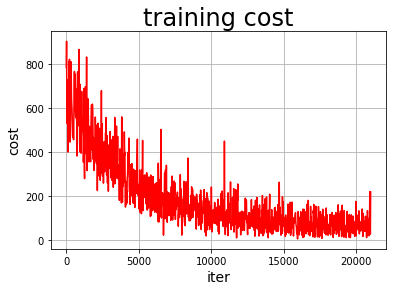

In [11]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)


# **Step5.模型预测**

**（1）创建预测用的Executor**

In [12]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [13]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 15.05
1: 15.20
2: 15.07
3: 16.41
4: 15.53
5: 16.07
6: 15.84
7: 15.56
8: 13.82
9: 15.49
10: 13.18
11: 14.53
12: 15.07
13: 14.68
14: 14.66
15: 15.43
16: 16.23
17: 16.14
18: 16.56
19: 15.37
20: 16.00
21: 14.77
22: 16.37
23: 15.77
24: 15.60
25: 15.12
26: 16.18
27: 16.04
28: 16.87
29: 15.89
30: 15.74
31: 15.16
32: 15.32
33: 14.41
34: 14.04
35: 15.54
36: 15.59
37: 16.00
38: 16.18
39: 16.03
40: 15.12
41: 14.89
42: 15.99
43: 16.22
44: 16.16
45: 15.94
46: 15.59
47: 16.29
48: 16.37
49: 16.62
50: 15.47
51: 15.68
52: 15.33
53: 15.57
54: 16.32
55: 16.65
56: 16.31
57: 16.69
58: 16.80
59: 17.07
60: 17.30
61: 17.21
62: 15.79
63: 16.29
64: 16.90
65: 17.38
66: 17.09
67: 17.48
68: 17.44
69: 17.73
70: 16.37
71: 15.98
72: 16.69
73: 15.57
74: 16.52
75: 17.01
76: 18.03
77: 18.27
78: 18.41
79: 18.29
80: 17.80
81: 18.08
82: 17.24
83: 17.80
84: 17.32
85: 16.63
86: 16.02
87: 17.39
88: 18.01
89: 21.00
90: 21.09
91: 20.90
92: 19.93
93: 20.66
94: 20.87
95: 20.43
96: 20.56
97: 21.70
9

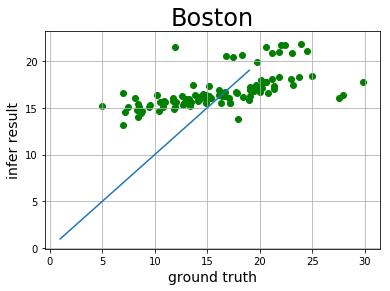

In [14]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)